<a href="https://colab.research.google.com/github/viktor-mashalov/Tax-Free-RSU-Transition/blob/main/tax_free_rsu_transition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RSU ticker symbol [MSFT]                : 
Simulation start date  YYYY-MM-DD [2015-06-13] : 
Simulation end date    YYYY-MM-DD [2025-06-13] : 
Loss-harvest & conversion begin date [2021-01-01]: 

YF.download() has changed argument auto_adjust default to True

======================= VESTING LOG =======================
      date  shares  vest_price
2015-06-30     100       38.28
2015-09-30     100       38.63
2015-12-31     100       48.75
2016-03-31     100       48.88
2016-06-30     100       45.60
2016-09-30     100       51.65
2017-01-03     100       56.50
2017-03-31     100       59.82
2017-06-30     100       62.97
2017-10-02     100       68.52
2018-01-02     100       79.33
2018-04-02     100       82.08
2018-07-02     100       93.14
2018-10-01     100      108.08
2018-12-31     100       95.37
2019-04-01     100      112.23
2019-07-01     100      128.41
2019-09-30     100      132.02
2019-12-31     100      150.26
2020-03-31     100      150.68
2020-06-30     100      194.9

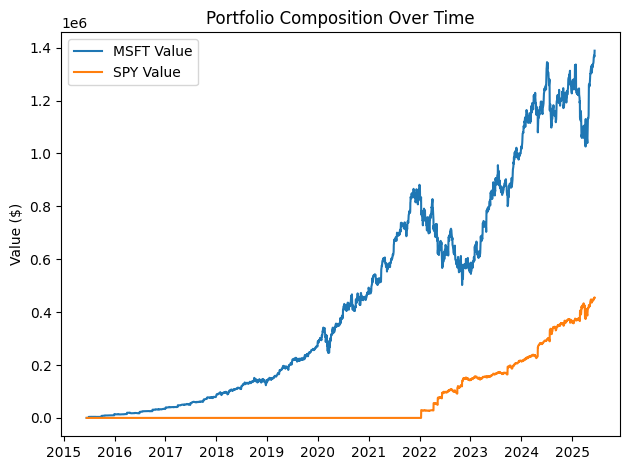

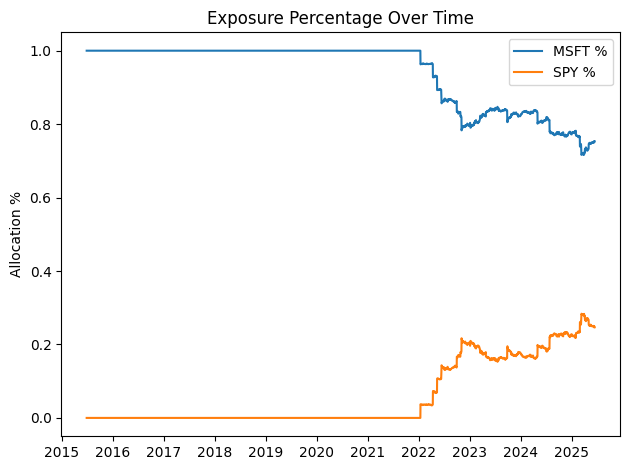

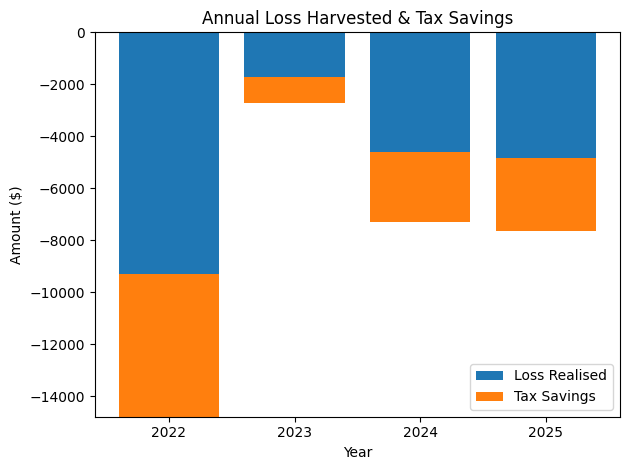

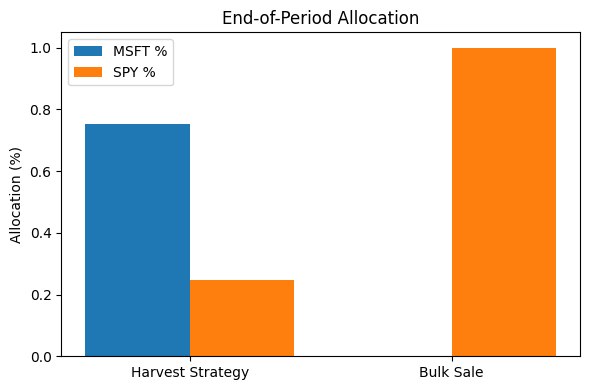

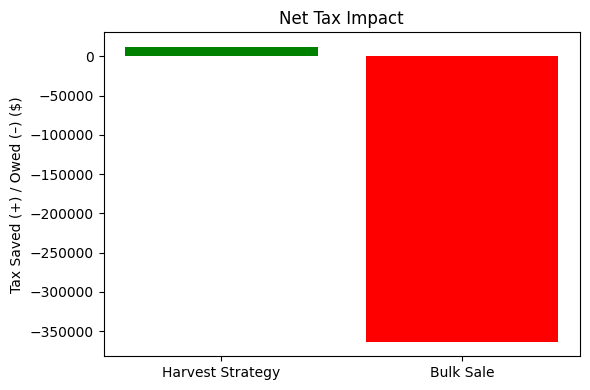

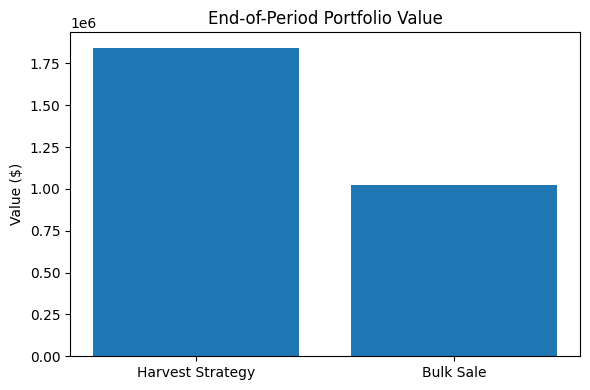

In [ ]:
#!/usr/bin/env python3
"""
####################################################################################################
DIRECT-INDEXING TAX-LOSS-HARVEST SIMULATOR
Author   : Viktor Mashalov

PROFESSIONAL DISCLAIMER  –  NOT FINANCIAL ADVICE
----------------------------------------------------------------------------------------------------
This script is provided strictly for educational and illustrative purposes.  Nothing herein
constitutes or should be construed as personalized investment advice, a solicitation, or a
recommendation to buy, sell, or hold any security or implement any strategy.  Past performance is
not indicative of future results.  Use entirely at your own risk.  Consult your own qualified
financial, tax, and legal advisers before acting on any information contained in or generated by
this program.  The author and all affiliated parties expressly disclaim any liability for losses,
damages, or costs of any kind arising out of the use of this material.
####################################################################################################
"""

# ----------------------------------------- IMPORTS ------------------------------------------------
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------- INTERACTIVE USER PARAMETERS -------------------------------------
# You can simply press <Enter> at any prompt to accept the default shown in [brackets].

ticker_rsu = input("RSU ticker symbol [MSFT]                : ").strip().upper() or "MSFT"
start_date = input("Simulation start date  YYYY-MM-DD [2015-06-13] : ").strip() or "2015-06-13"
end_date   = input("Simulation end date    YYYY-MM-DD [2025-06-13] : ").strip() or "2025-06-13"

transition_start_date = (
    input("Loss-harvest & conversion begin date [2021-01-01]: ").strip()
    or "2021-01-01"
)

# --------------------------- STATIC PARAMETERS (EDIT IF DESIRED) ---------------------------------
benchmark_etf        = "SPY"      # ETF into which RSU proceeds are rolled
vest_freq            = "QE-DEC"   # Quarterly vest schedule (Mar/Jun/Sep/Dec)
shares_per_vest      = 100        # Shares that vest each quarter
harvest_loss_pct     = 0.08       # Trigger: % below basis to harvest
assumed_tax_rate     = 0.37       # Marginal tax bracket for savings estimate

# ------------------------------- FETCH PRICE DATA -------------------------------------------------
print(f"\nDownloading price history for {ticker_rsu} and {benchmark_etf} …")
price_rsu = yf.download(ticker_rsu, start=start_date, end=end_date, progress=False)["Close"]
price_etf = yf.download(benchmark_etf, start=start_date, end=end_date, progress=False)["Close"]

# Combine & clean
df = pd.concat([price_rsu, price_etf], axis=1).dropna()
df.columns = ["rsu", "etf"]

# ----------------------------- BUILD VESTING CALENDAR --------------------------------------------
vest_anchor = pd.date_range(start=df.index.min(), end=df.index.max(), freq=vest_freq)
vest_dates  = [df.index[pos] for pos in df.index.searchsorted(vest_anchor) if pos < len(df.index)]

# ------------------------------- INITIALISE STATE -------------------------------------------------
transition_start = pd.to_datetime(transition_start_date)

rsu_lots   = []   # open RSU lots
vest_log   = []   # details of each vest event
trade_log  = []   # harvest-sale events
daily_snap = []   # daily portfolio valuation

# ------------------------------------- MAIN LOOP --------------------------------------------------
for today, prices in df.iterrows():
    rsu_px, etf_px = prices["rsu"], prices["etf"]

    # (a) Vesting
    if today in vest_dates:
        rsu_lots.append({"shares": shares_per_vest, "basis": rsu_px})
        vest_log.append({"date": today, "shares": shares_per_vest, "vest_price": rsu_px})

    # (b) Harvesting after transition start
    if today >= transition_start:
        for lot in rsu_lots.copy():
            if rsu_px < lot["basis"] * (1 - harvest_loss_pct):
                shares, basis = lot["shares"], lot["basis"]
                proceeds      = shares * rsu_px
                loss_amount   = shares * (rsu_px - basis)
                tax_savings   = -loss_amount * assumed_tax_rate

                rsu_lots.remove(lot)
                trade_log.append({
                    "date": today,
                    "shares_sold": shares,
                    "basis": basis,
                    "sale_price": rsu_px,
                    "loss": loss_amount,
                    "tax_savings": tax_savings,
                    "etf_shares_bought": proceeds / etf_px
                })

    # (c) Accumulated ETF shares
    total_etf_shares = sum(t["etf_shares_bought"] for t in trade_log)

    # (d) Daily snapshot
    total_rsu_shares = sum(l["shares"] for l in rsu_lots)
    val_rsu          = total_rsu_shares * rsu_px
    val_etf          = total_etf_shares  * etf_px
    total_val        = val_rsu + val_etf

    daily_snap.append({
        "date": today,
        f"{ticker_rsu}_Shares": total_rsu_shares,
        f"{benchmark_etf}_Shares": total_etf_shares,
        f"{ticker_rsu}_Value": val_rsu,
        f"{benchmark_etf}_Value": val_etf,
        "Total_Value": total_val,
        "Cumulative_Loss": sum(t["loss"] for t in trade_log),
        "Estimated_Tax_Savings": sum(t["tax_savings"] for t in trade_log)
    })

# --------------------------- CONVERT LOGS TO DATAFRAMES -------------------------------------------
results_df = pd.DataFrame(daily_snap).set_index("date")
vest_df    = pd.DataFrame(vest_log).assign(year=lambda x: x["date"].dt.year)
trades_df  = pd.DataFrame(trade_log)
if not trades_df.empty:
    trades_df["year"] = trades_df["date"].dt.year

# -------------------------- FINAL SNAPSHOT & COMPARISONS ------------------------------------------
final_date        = results_df.index[-1]
rsu_px_end        = df.loc[final_date, "rsu"]
etf_px_end        = df.loc[final_date, "etf"]
final_rec         = results_df.iloc[-1]

final_rsu_shares  = final_rec[f"{ticker_rsu}_Shares"]
final_etf_shares  = final_rec[f"{benchmark_etf}_Shares"]
final_port_value  = final_rec["Total_Value"]
tax_savings_strat = final_rec["Estimated_Tax_Savings"]

strat_rsu_pct = (final_rsu_shares * rsu_px_end) / final_port_value
strat_etf_pct = (final_etf_shares * etf_px_end) / final_port_value

# Bulk-sale scenario
remaining_lots      = rsu_lots.copy()
bulk_shares         = sum(l["shares"] for l in remaining_lots)
gross_proceeds_bulk = bulk_shares * rsu_px_end
gain_amount         = sum(l["shares"] * max(0, rsu_px_end - l["basis"]) for l in remaining_lots)
tax_liability_bulk  = gain_amount * assumed_tax_rate
net_proceeds_bulk   = gross_proceeds_bulk - tax_liability_bulk
bulk_etf_shares     = net_proceeds_bulk / etf_px_end
value_etf_bulk      = bulk_etf_shares * etf_px_end

# ------------------------------ PRINT TEXT OUTPUT -------------------------------------------------
pd.set_option("display.float_format", "{:,.2f}".format)

print("\n======================= VESTING LOG =======================")
print(vest_df[["date", "shares", "vest_price"]].to_string(index=False))

print("\n================== VESTED SHARES BY YEAR ==================")
print(vest_df.groupby("year").agg(total_vested_shares=("shares","sum"),
                                  avg_vest_price=("vest_price","mean")).to_string())

if not trades_df.empty:
    print("\n==================== HARVEST TRADES LOG ==================")
    print(trades_df[["date","shares_sold","basis","sale_price",
                     "loss","tax_savings","etf_shares_bought"]].to_string(index=False))

    print("\n================= REALISED LOSS & TAX SAVINGS ============")
    print(trades_df.groupby("year").agg(loss_realised=("loss","sum"),
                                        tax_savings=("tax_savings","sum")).to_string())

print(f"\n================= END-OF-PERIOD (as of {final_date.date()}) ================")
print("Tax-Loss-Harvest Strategy")
print(f"  • Portfolio Value    : ${final_port_value:,.2f}")
print(f"  • {ticker_rsu} Allocation : {strat_rsu_pct:.1%}")
print(f"  • {benchmark_etf} Allocation : {strat_etf_pct:.1%}")
print(f"  • Net Tax Impact     : \033[92m${tax_savings_strat:,.2f} saved\033[0m\n")

print("All-at-Once Bulk Sale")
print(f"  • Gross Proceeds     : ${gross_proceeds_bulk:,.2f}")
print(f"  • Net Tax Impact     : \033[91m${tax_liability_bulk:,.2f} owed\033[0m")
print(f"  • Net Proceeds       : ${net_proceeds_bulk:,.2f}")

# --------------------------------------- PLOTTING -------------------------------------------------
plt.style.use("default")

# (1) Value timeline
fig, ax = plt.subplots()
ax.plot(results_df.index, results_df[f"{ticker_rsu}_Value"], label=f"{ticker_rsu} Value")
ax.plot(results_df.index, results_df[f"{benchmark_etf}_Value"], label=f"{benchmark_etf} Value")
ax.set_title("Portfolio Composition Over Time")
ax.set_ylabel("Value ($)")
ax.legend()
plt.tight_layout()
plt.show()

# (2) Allocation %
fig2, ax2 = plt.subplots()
ax2.plot(results_df.index,
         results_df[f"{ticker_rsu}_Value"] / results_df["Total_Value"],
         label=f"{ticker_rsu} %")
ax2.plot(results_df.index,
         results_df[f"{benchmark_etf}_Value"] / results_df["Total_Value"],
         label=f"{benchmark_etf} %")
ax2.set_title("Exposure Percentage Over Time")
ax2.set_ylabel("Allocation %")
ax2.legend()
plt.tight_layout()
plt.show()

# (3) Annual realised loss & tax savings
if not trades_df.empty:
    yearly = trades_df.groupby("year").agg(loss=("loss","sum"), tax=("tax_savings","sum"))
    fig3, ax3 = plt.subplots()
    ax3.bar(yearly.index.astype(str), yearly["loss"], label="Loss Realised")
    ax3.bar(yearly.index.astype(str), yearly["tax"], bottom=yearly["loss"],
            label="Tax Savings")
    ax3.set_title("Annual Loss Harvested & Tax Savings")
    ax3.set_xlabel("Year")
    ax3.set_ylabel("Amount ($)")
    ax3.legend()
    plt.tight_layout()
    plt.show()

# (4) Allocation comparison
fig4, ax4 = plt.subplots(figsize=(6,4))
x, width = np.arange(2), 0.4
ax4.bar(x - width/2, [strat_rsu_pct, 0],     width, label=f"{ticker_rsu} %")
ax4.bar(x + width/2, [strat_etf_pct, 1.0],   width, label=f"{benchmark_etf} %")
ax4.set_xticks(x)
ax4.set_xticklabels(["Harvest Strategy", "Bulk Sale"])
ax4.set_title("End-of-Period Allocation")
ax4.set_ylabel("Allocation (%)")
ax4.legend()
plt.tight_layout()
plt.show()

# (5) Net tax comparison
fig5, ax5 = plt.subplots(figsize=(6,4))
labels = ["Harvest Strategy", "Bulk Sale"]
impact = [tax_savings_strat, -tax_liability_bulk]
ax5.bar(labels, impact, color=["green" if v>=0 else "red" for v in impact])
ax5.set_title("Net Tax Impact")
ax5.set_ylabel("Tax Saved (+) / Owed (–) ($)")
plt.tight_layout()
plt.show()

# (6) Portfolio value comparison
fig6, ax6 = plt.subplots(figsize=(6,4))
ax6.bar(["Harvest Strategy","Bulk Sale"],
        [final_port_value, value_etf_bulk])
ax6.set_title("End-of-Period Portfolio Value")
ax6.set_ylabel("Value ($)")
plt.tight_layout()
plt.show()